In [69]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


# Cómo Estimamos el SNR en entornos de Hardware Real

## Primera Técnica: Estimación de SNR por Escala Compleja (α) LS



Esta sección explica **cómo estimamos la SNR de un payload LoRa recibido** comparándolo con su versión ideal remodulada, usando un **modelo de ganancia/fase compleja único** y un cálculo de potencia de residuo.

### Idea



Alineamos el payload recibido con el ideal, encontramos el escalar complejo `alpha` que mejor lo ajusta en el sentido de mínimos cuadrados, y medimos cuánta energía queda como residuo. La relación señal/residuo es la **SNR estimada**.



### Modelo



Para simplificar la estimación, se considera que el canal es estático durante el payload y no introduce distorsiones temporales significativas. Por lo tanto, toda la señal recibida es modelada como una copia escalada (en ganancia y fase) de la señal transmitida, más ruido.

$$\displaystyle r[k] = \alpha \cdot s[k] + n[k]$$


* $r[k]$: muestra recibida (payload ya alineado al inicio real del payload).
* $s[k]$: muestra ideal (payload remodulado con los mismos parámetros PHY; sin preámbulo).
* $\space\space \alpha \space\space$:  escala compleja (ganancia + fase) desconocida.
* $n[k]$: ruido + distorsión no modelada.

Buscamos $\alpha$ que minimiza $\sum_k |r[k] - \alpha s[k]|^2$. La solución analítica se modela de esta forma, debido al principio de Mínimos Cuadrados o Least Squares:

$$\displaystyle \alpha = \frac{\sum_k r[k] s^*[k]}{\sum_k |s[k]|^2}$$

Esta expresión surge de proyectar la señal recibida sobre la señal ideal en el espacio complejo, lo que corresponde a una estimación de mínimos cuadrados del escalar complejo que mejor ajusta una sobre la otra.




### Potencias y SNR

Una vez estimado `alpha`:

```python
reconstructed_signal = alpha * s
noise_waveform      = r - reconstructed_signal
signal_power = mean(|reconstructed_signal|**2)
noise_power  = mean(|noise_waveform|**2)
SNR_linear   = signal_power / noise_power
SNR_dB       = 10 * log10(SNR_linear)
```

Se aplica un *power floor* para evitar divisiones por cero en casos desfavorables o extremoss.


### Flujo de uso




1. **Remodular** el payload decodificado -> `ideal_payload_waveform` (solo payload).

2. **Alinear** la captura Rx al inicio del payload -> `received_payload_waveform`.

3. **Igualar longitudes** (se trunca al mínimo; no se rellena por defecto).

4. **Estimar α** con `_estimate_complex_scale_ls()`.

5. **Calcular SNR** con `_snr_from_alpha_and_waveforms()` o el wrapper `estimate_snr_alpha_ls()`.



### API rápida




*estimate_snr_from_ls_fit(received, ideal, return_extras=False, power_floor=1e-18)*

Función de alto nivel: ejecuta los pasos previos y devuelve SNR en dB. Con *return_extras=True* devuelve también dict con SNR lineal, *alpha*, potencias y número de muestras.

In [70]:
import numpy as np

def signal_power(signal: np.ndarray) -> float:
    """Return average power after mean removal."""
    return np.mean(np.abs(signal - np.mean(signal))**2)

def generate_awgn(snr_input, clean_signal: np.ndarray):
    """Add complex AWGN to reach desired SNR relative to signal_power(clean_signal)."""
    if isinstance(snr_input, str) and snr_input.lower().endswith('db'):
        snr_linear = 10 ** (float(snr_input[:-2]) / 10.0)
    else:
        snr_linear = float(snr_input)
    if snr_linear <= 0:
        raise ValueError("SNR must be positive.")
    sig_var = signal_power(clean_signal)
    noise_var = sig_var / snr_linear
    noise = np.sqrt(noise_var / 2.0) * (
        np.random.randn(clean_signal.size) + 1j * np.random.randn(clean_signal.size)
    )
    return clean_signal + noise, noise, noise_var

In [ ]:
import numpy as np
from typing import Tuple, Dict, Any


def _coerce_complex_1d(waveform: np.ndarray) -> np.ndarray:
    """Return waveform as a 1-D complex64 NumPy array."""
    return np.asarray(waveform, dtype=np.complex64).ravel()


def _match_lengths(
    received_waveform: np.ndarray,
    ideal_waveform: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Truncate both arrays to the same (shorter) length.
    
    :param received_waveform: Received waveform array.
    :type received_waveform: np.ndarray
    :param ideal_waveform: Ideal waveform array.
    :type ideal_waveform: np.ndarray

    :return: Tuple of truncated received and ideal waveforms.
    :rtype: Tuple[np.ndarray, np.ndarray]
    """
    common_length = min(received_waveform.size, ideal_waveform.size)
    return received_waveform[:common_length], ideal_waveform[:common_length]


import numpy as np
from typing import Optional

import numpy as np

def _estimate_complex_scale_ls(
    received_waveform: np.ndarray,
    ideal_waveform: np.ndarray,
    *,
    power_floor: float = 1e-18,
) -> complex:
    """
    Compute least-squares complex scale `alpha` mapping ideal -> received.

    `alpha = sum(received * conj(ideal)) / sum(|ideal|**2)`

    :param received_waveform: Measured complex samples (r[k]).
    :type received_waveform: np.ndarray
    :param ideal_waveform: Reference complex samples (s[k]); same length or pre-trimmed.
    :type ideal_waveform: np.ndarray
    :param power_floor: Minimum energy guard; return 0j if ideal energy below this.
    :type power_floor: float

    :return: Complex scale alpha.
    :rtype: complex
    """
    ideal_energy = np.sum(np.abs(ideal_waveform) ** 2)
    if ideal_energy <= power_floor:
        return 0j
    numerator = np.sum(received_waveform * np.conj(ideal_waveform))

    alpha = numerator / ideal_energy
    return alpha

def _snr_from_alpha_and_waveforms(
    received_waveform: np.ndarray,
    ideal_waveform: np.ndarray,
    alpha: complex,
    *,
    power_floor: float = 1e-18,
) -> Tuple[float, float, float]:
    """
    Compute linear SNR plus component powers using a precomputed complex scale.

    signal = alpha * ideal
    noise  = received - signal

    :param received_waveform: Measured complex samples (r[k]).
    :type received_waveform: np.ndarray
    :param ideal_waveform: Reference complex samples (s[k]); same length as received.
    :type ideal_waveform: np.ndarray
    :param alpha: Complex scale mapping ideal -> received.
    :type alpha: complex
    :param power_floor: Minimum noise power guard; if noise <= floor, SNR=inf.
    :type power_floor: float

    :return: (snr_linear, signal_power, noise_power)
    :rtype: Tuple[float, float, float]
    """
    reconstructed_signal = alpha * ideal_waveform
    noise_waveform = received_waveform - reconstructed_signal

    signal_power = np.mean(np.abs(reconstructed_signal) ** 2)
    noise_power = np.mean(np.abs(noise_waveform) ** 2)

    if noise_power <= power_floor:
        return np.inf, signal_power, noise_power

    snr_linear = signal_power / noise_power
    return snr_linear, signal_power, noise_power


def estimate_snr_from_ls_fit(
    received_payload_waveform: np.ndarray,
    ideal_payload_waveform: np.ndarray,
    *,
    return_extras: bool = False,
    power_floor: float = 1e-18,
) -> float | Tuple[float, Dict[str, Any]]:
    """
    LS-fit complex scale `alpha` between aligned received/ideal payloads and return SNR (dB).

    Steps: coerce → length match → `alpha` LS → residual powers → SNR.

    :param received_payload_waveform: Measured payload samples (aligned to payload start).
    :type received_payload_waveform: np.ndarray
    :param ideal_payload_waveform: Remodulated payload samples (reference).
    :type ideal_payload_waveform: np.ndarray
    :param return_extras: If True, also return dict with linear SNR, `alpha`, powers, length.
    :type return_extras: bool
    :param power_floor: Energy/power guard to avoid divide-by-zero.
    :type power_floor: float
    :return: SNR in dB, or (snr_db, extras_dict) if return_extras True.
    :rtype: float | Tuple[float, Dict[str, Any]]
    """
    received = _coerce_complex_1d(received_payload_waveform)
    ideal = _coerce_complex_1d(ideal_payload_waveform)

    if received.size == 0 or ideal.size == 0:
        snr_db = float("-inf")
        if return_extras:
            return snr_db, {
                "snr_linear": 0.0,
                "alpha": 0.0 + 0.0j,
                "signal_power": 0.0,
                "noise_power": 0.0,
                "num_samples": 0,
            }
        return snr_db

    received, ideal = _match_lengths(received, ideal) # LS method requires same length (remember: sum_k)

    alpha = _estimate_complex_scale_ls(
        received, ideal, power_floor=power_floor
    )
    snr_linear, signal_power, noise_power = _snr_from_alpha_and_waveforms(
        received, ideal, alpha, power_floor=power_floor
    )

    snr_db = float("inf") if not np.isfinite(snr_linear) else 10.0 * np.log10(snr_linear)

    if return_extras:
        return snr_db, {
            "snr_linear": snr_linear,
            "alpha": alpha,
            "signal_power": signal_power,
            "noise_power": noise_power,
            "num_samples": ideal.size,
        }

    return snr_db


In [72]:
# ---------------------------------------------------------------------------
# Core objects
# ---------------------------------------------------------------------------


from src.core.params import LoRaPhyParams, LoRaFrameParams
from src.mod.modulator import LoRaModulator
from src.mod.mod_viz import plot_frame
from src.demod.demodulator import LoRaDemodulator
from src.sync.dechirp_based_synchronizer import DechirpBasedSynchronizer as Synchronizer
import src.core.snr_utils as snr_utils

In [73]:
# LoRa PHY and frame parameters
# These parameters are used for both modulation and demodulation.

phy_params = LoRaPhyParams(
    spreading_factor=7,
    bandwidth=125e3,
    samples_per_chip=2
)

frame_params = LoRaFrameParams(
    preamble_symbol_count=8,
    explicit_header=True,
    sync_word=0x00
)


In [89]:
payload_len = 1000
snr_db = "-10db"

modulator = LoRaModulator(phy_params, frame_params, backend="numpy")
demodulator = LoRaDemodulator(phy_params)

import numpy as np
payload = [np.random.randint(0, phy_params.chips_per_symbol) for _ in range(payload_len)]  # Example payload

modulated_signal = modulator.modulate(payload, include_frame=False)

noisy, _, _ = generate_awgn(snr_db, modulated_signal)

snr_estimation = estimate_snr_from_ls_fit(
    noisy,
    modulated_signal
)

print(f"SNR Objetivo: {snr_db}")
print(f"SNR estimado mediante mínimos cuadrados: {snr_estimation:.2f} dB")

snr_estimation = snr_utils.estimate_snr_from_ls_fit_segmented(
    noisy,
    modulated_signal,
    sps=phy_params.samples_per_symbol,
    seg_syms=4
)

print(f"SNR Objetivo: {snr_db}")
print(f"SNR estimado mediante mínimos cuadrados y el payload en segmentos: {snr_estimation:.2f} dB")



SNR Objetivo: -10db
SNR estimado mediante mínimos cuadrados: -10.06 dB
SNR Objetivo: -10db
SNR estimado mediante mínimos cuadrados y el payload en segmentos: -10.02 dB


### Problemas con esta técnica

Debido a que el estimador es en esencia un correlador y tal como se explica en el segundo paper de LoRa, en cuanto se lleve a cabo esta técnica en presencia de una disposición de Hardware Real, el CFO y otros artefactos comunes en el ecosistema del SDR (Imbalance IQ, SFO, DC Continua o Drift) no permiten que el resultado sea coherente con los valores reales de SNR. Por lo tanto, se exploran otras técnicas más aptas para un entorno de SDRs (duales).

## Segunda Técnica: Estimación del SNR mediante Bins de la FFT


Cuando la estimación por mínimos cuadrados no se ajusta bien a las condiciones particulares de un entorno con múltiples SDRs, puede recurrirse a una estrategia alternativa basada en los bins de la FFT obtenidos durante la demodulación LoRa.




### Procedimiento



1. **Demodulación con estado intermedio**  
   Se demodula el payload de manera habitual, con la diferencia de que se solicita al demodulador que devuelva el estado intermedio de la FFT ya decimada o *folded*, según el método de alineamiento empleado (CPA, FPA o 0FPA).

2. **Cálculo de la dominancia relativa**  
   Dado el conocimiento previo del bin que debería contener la mayor magnitud (es decir, el bin correspondiente al símbolo transmitido), se evalúa su **dominancia relativa** respecto al resto del espectro:

   $$
   \text{Dominancia relativa} = \frac{P_s}{\sum_k P_k}
   $$

   Donde:
   - $P_s$ es la potencia del bin correspondiente al símbolo correcto (índice = símbolo),
   - $\sum_k P_k$ es la suma de potencias de todos los bins de la FFT para ese símbolo.

Esta métrica permite construir, en un entorno simulado, una curva de referencia que relaciona la dominancia relativa con el SNR. Posteriormente, al trabajar sobre hardware real, se puede **estimar el SNR** observando la dominancia relativa obtenida al demodular un payload y contrastándola con la curva simulada.

Esto se apoya a que la relación entre el SNR y la potencia espectral de los bins es lineal en escala logarítmica ya que se ajusta a una curva del estilo: 

$$ D_{rel}[dB]= 10 \log _{10}(D_{rel})$$
$$D_{rel}[dB] = m\cdot SNR_{dB} + b$$

In [75]:
payload_len = 1000
snr_db = "-10db"

modulator = LoRaModulator(phy_params, frame_params, backend="numpy")
demodulator = LoRaDemodulator(phy_params)

import numpy as np
payload = [np.random.randint(0, phy_params.chips_per_symbol) for _ in range(payload_len)]  # Example payload

modulated_signal = modulator.modulate(payload, include_frame=False)

noisy, _, _ = generate_awgn(snr_db, modulated_signal)





In [76]:
import numpy as np

def split_folded_fft(folded_flat: np.ndarray, chips_per_symbol: int) -> np.ndarray:
    """
    Splits a flattened folded FFT array into chunks per symbol.

    Parameters
    ----------
    folded_flat : np.ndarray
        Flattened 1D array of folded FFT magnitudes or complex values.
    chips_per_symbol : int
        Number of FFT bins (i.e., chips per symbol).

    Returns
    -------
    np.ndarray of shape (N_syms, chips_per_symbol)
    """
    if folded_flat.ndim != 1:
        raise ValueError("folded_flat must be a 1D array")

    if len(folded_flat) % chips_per_symbol != 0:
        raise ValueError("folded length not divisible by chips_per_symbol")

    return folded_flat.reshape(-1, chips_per_symbol)


In [77]:
def relative_dominance(symbol: int, folded_chunk: np.ndarray) -> float | None:
    """
    Computes relative dominance: correct bin power / total power,
    only if the correct bin matches the detected peak.

    Parameters
    ----------
    symbol : int
        Transmitted symbol index (ground-truth).
    folded_chunk : np.ndarray
        Array of shape (chips,) with magnitudes or complex values.

    Returns
    -------
    float or None
        Dominance ratio if peak == symbol, otherwise None.
    """
    powers = np.abs(folded_chunk)**2
    peak_idx = np.argmax(powers)
    if peak_idx != symbol:
        return None
    return powers[symbol] / np.sum(powers)


For -10 SNR:
Relative Dominance of the good bin over the rest: 0.0319911390542984
For -9 SNR:
Relative Dominance of the good bin over the rest: 0.035631682723760605
For -8 SNR:
Relative Dominance of the good bin over the rest: 0.0389004684984684
For -7 SNR:
Relative Dominance of the good bin over the rest: 0.04331754893064499
For -6 SNR:
Relative Dominance of the good bin over the rest: 0.048597775399684906
For -5 SNR:
Relative Dominance of the good bin over the rest: 0.05425265058875084
For -4 SNR:
Relative Dominance of the good bin over the rest: 0.060153938829898834
For -3 SNR:
Relative Dominance of the good bin over the rest: 0.06696095317602158
For -2 SNR:
Relative Dominance of the good bin over the rest: 0.07432565093040466
For -1 SNR:
Relative Dominance of the good bin over the rest: 0.08252532035112381
For 0 SNR:
Relative Dominance of the good bin over the rest: 0.09173775464296341
SNR: -10 dB, Relative Dominance: 0.0319911390542984
SNR: -9 dB, Relative Dominance: 0.03563168272

Text(0, 0.5, 'Relative Dominance (log scale)')

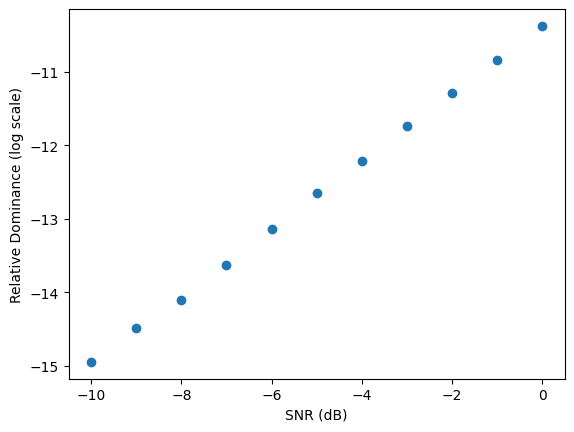

In [78]:
def linear_regression(x, y):
    """
    Fits y = m * x + b using least squares.
    
    Parameters:
        x, y : 1D arrays of the same length.
        
    Returns:
        m, b : slope and intercept
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if x.ndim != 1 or y.ndim != 1:
        raise ValueError("x and y must be 1D arrays")
    if len(x) != len(y):
        raise ValueError("x and y must have the same length")

    # Mean values
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Least squares formulas
    num = np.sum((x - x_mean) * (y - y_mean))
    den = np.sum((x - x_mean)**2)
    m = num / den
    b = y_mean - m * x_mean
    return m, b

payload_len = 1000
snr_db_list = list(range(-10, 1, 1)) 

results = []
db_results = []
for snr_db in snr_db_list:
    modulator = LoRaModulator(phy_params, frame_params, backend="numpy")
    demodulator = LoRaDemodulator(phy_params)
    import numpy as np
    payload = [np.random.randint(0, phy_params.chips_per_symbol) for _ in range(payload_len)]  # Example payload

    modulated_signal = modulator.modulate(payload, include_frame=False)

    noisy, _, _ = generate_awgn(f"{snr_db}db", modulated_signal)

    demod_symbols, folded = demodulator.demodulate(noisy, return_items=["symbols", "folded"])


    # Divide folded array into arrays of 128 samples

    folded_chunks = np.split(folded.get(), len(folded) // phy_params.chips_per_symbol)
    rel_dominances = []
    for i, chunk in enumerate(folded_chunks):
        sent_symbol = payload[i]
        if sent_symbol != demod_symbols[i]:
            continue
        rel_dominance = chunk[payload[i]] / np.sum(chunk)
        rel_dominances.append(rel_dominance)
    result = np.mean(rel_dominances)
    results.append(result)
    db_results.append(10 * np.log10(result))  # Convert to dB scale
    print(f"For {snr_db} SNR:")
    print(f"Relative Dominance of the good bin over the rest: {result}")

for i in range(len(results)):
    print(f"SNR: {snr_db_list[i]} dB, Relative Dominance: {results[i]}")

# Linear regression of results with numpy

m, b = linear_regression(snr_db_list, results)
import matplotlib.pyplot as plt
plt.plot(snr_db_list, db_results, 'o', label='Data points')
plt.xlabel('SNR (dB)')
plt.ylabel('Relative Dominance (log scale)')
#plt.yscale('log')



In [79]:
import numpy as np

def _to_numpy(a):
    """Return a NumPy array, handling CuPy via .get() if present."""
    return a.get() if hasattr(a, "get") else np.asarray(a)

def _dominance_from_folded(
    folded, chips_per_symbol: int, symbol_indices=None, *, filter_to_argmax: bool = False
):
    """
    Compute mean relative dominance from a `folded` vector.

    folded: 1D array, concatenation of per-symbol folded spectra.
    chips_per_symbol: length of each per-symbol chunk inside folded.
    symbol_indices: optional 1D array of bin indices (truth or decoded) per chunk.
    filter_to_argmax: if True, only use chunks where argmax(chunk) == symbol_indices[i].

    Returns
    -------
    mean_dom_linear : float
    used_count : int
    """
    f = _to_numpy(folded).ravel()
    if f.size % chips_per_symbol != 0:
        raise ValueError("`folded` length must be a multiple of chips_per_symbol")
    S = f.size // chips_per_symbol
    chunks = np.split(f, S)

    if symbol_indices is not None:
        sym_idx = np.asarray(symbol_indices).ravel()
        if sym_idx.size != S:
            raise ValueError("`symbol_indices` length must match number of chunks in `folded`")
    else:
        sym_idx = None

    doms = []
    for i, chunk in enumerate(chunks):
        denom = float(np.sum(chunk))
        if denom <= 0:
            continue  # skip pathological chunk
        if sym_idx is None:
            k = int(np.argmax(chunk))
        else:
            k = int(sym_idx[i])
            if filter_to_argmax and (k != int(np.argmax(chunk))):
                continue  # keep only “correct” chunks

        num = float(chunk[k])
        if num <= 0:
            continue
        doms.append(num / denom)

    if not doms:
        raise ValueError("No usable chunks to compute dominance (check inputs / filters).")

    return float(np.mean(doms)), len(doms)

def build_snr_calibrator_from_folded(
    snr_db_list,
    folded_list,
    *,
    chips_per_symbol: int,
    symbol_indices_list=None,          # list of arrays (truth or decoded) aligned with folded_list; optional
    filter_to_argmax: bool = True      # mimic your original “usar solo símbolos bien decodificados”
):
    """
    Fit: 10*log10(mean_dominance_from_folded) = m * SNR_dB + b

    Parameters
    ----------
    snr_db_list : array-like of shape (N,)
        SNRs (dB) usados para calibración.
    folded_list : list of 1D arrays
        Cada elemento es el `folded` devuelto por demodulate() para esa SNR.
    chips_per_symbol : int
        Largo de cada chunk dentro de `folded`.
    symbol_indices_list : list of 1D arrays or None
        Índices por símbolo para evaluar la dominancia (p.ej. payload “verdad” durante calibración).
        Si se pasa y `filter_to_argmax=True`, se usan solo los chunks donde
        argmax(chunk) == symbol_indices[i].
        Si es None, se usa argmax de cada chunk (sin filtro).
    filter_to_argmax : bool
        Ver arriba.

    Returns
    -------
    snr_from_folded : callable
        f(folded, symbol_indices=None) -> SNR_dB
        - `folded`: vector tal cual lo devuelve `demodulate(..., return_items=["folded"])`
        - `symbol_indices` opcional: si lo pasás en inferencia, evalúa dominancia en ese bin;
          si no, usa argmax por chunk.
    coeffs : dict
        {'m': m, 'b': b, 'r2': r2, 'used_per_fit': [counts...]}
    """
    x = np.asarray(snr_db_list, dtype=float).ravel()
    if len(folded_list) != x.size:
        raise ValueError("folded_list length must match snr_db_list length")

    y_db = []
    used_counts = []
    for i, folded in enumerate(folded_list):
        sym_idx = None if symbol_indices_list is None else symbol_indices_list[i]
        dom_lin, used = _dominance_from_folded(
            folded, chips_per_symbol, sym_idx, filter_to_argmax=filter_to_argmax
        )
        if dom_lin <= 0:
            raise ValueError("Computed non-positive dominance; check inputs.")
        y_db.append(10.0 * np.log10(dom_lin))
        used_counts.append(int(used))

    y_db = np.asarray(y_db, dtype=float)

    # Least-squares fit y = m*x + b
    x_mean, y_mean = x.mean(), y_db.mean()
    num = np.sum((x - x_mean) * (y_db - y_mean))
    den = np.sum((x - x_mean) ** 2)
    if den == 0:
        raise ValueError("All SNR points are identical; cannot fit a line.")
    m = num / den
    b = y_mean - m * x_mean

    # R^2
    y_hat = m * x + b
    ss_res = np.sum((y_db - y_hat) ** 2)
    ss_tot = np.sum((y_db - y_mean) ** 2)
    r2 = np.nan if ss_tot == 0 else (1.0 - ss_res / ss_tot)

    def snr_from_folded(folded, symbol_indices=None):
        """
        Estimate SNR(dB) from a fresh `folded` vector (and optional indices).
        """
        dom_lin, used = _dominance_from_folded(
            folded, chips_per_symbol, symbol_indices, filter_to_argmax=filter_to_argmax
        )
        y_obs_db = 10.0 * np.log10(dom_lin)
        return (y_obs_db - b) / m

    return snr_from_folded, {'m': m, 'b': b, 'r2': r2, 'used_per_fit': used_counts}


In [80]:
import numpy as np

# Asumimos que ya tenés: phy_params, frame_params, generate_awgn,
# build_snr_calibrator_from_folded (definida antes), LoRaModulator, LoRaDemodulator

payload_len   = 1000
snr_db_list   = list(range(-10, 1, 1))  # [-10, -9, ..., 0]
chips_per_sym = phy_params.chips_per_symbol

modulator   = LoRaModulator(phy_params, frame_params, backend="numpy")
demodulator = LoRaDemodulator(phy_params)

folded_list        = []
tx_symbols_per_snr = []

for snr_db in snr_db_list:
    # Payload "verdad" para este punto
    payload = np.random.randint(0, chips_per_sym, size=payload_len).tolist()
    tx_symbols_per_snr.append(np.asarray(payload, dtype=int))

    # Modulación y canal AWGN
    waveform = modulator.modulate(payload, include_frame=False)
    noisy, _, _ = generate_awgn(f"{snr_db}db", waveform)

    # Demodulación (necesitamos el folded)
    _, folded = demodulator.demodulate(noisy, return_items=["symbols", "folded"])
    folded_list.append(folded)

# Calibración: usa la verdad y filtra a los chunks donde argmax == verdad
snr_from_folded, coeffs = build_snr_calibrator_from_folded(
    snr_db_list,
    folded_list,
    chips_per_symbol=chips_per_sym,
    symbol_indices_list=tx_symbols_per_snr,
    filter_to_argmax=True
)

print("Coeficientes:", coeffs)




Coeficientes: {'m': np.float64(0.46232097551437257), 'b': np.float64(-10.37617355521387), 'r2': np.float64(0.9999507323823423), 'used_per_fit': [955, 984, 999, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]}


In [ ]:
wanted_snr_db = "-10db"
payload = np.random.randint(0, chips_per_sym, size=1000).tolist()
modulated_signal = modulator.modulate(payload, include_frame=False)
noisy, _, _ = generate_awgn(wanted_snr_db, modulated_signal)
demod_symbols, folded = demodulator.demodulate(noisy, return_items=["symbols", "folded"])
# Usar el calibrador para estimar SNR
snr_est_db = snr_from_folded(folded, symbol_indices=demod_symbols.get())
print(f"Wanted SNR: {wanted_snr_db}")
print(f"Estimated SNR from folded: {snr_est_db:.2f} dB")


Wanted SNR: -10db
Estimated SNR from folded: -10.04 dB


### Problemas con esta técnica

1. Como depende de poder haber demodulado correctamente el payload, es impractica para medir SNR en entornos muy ruidosos, ya que se necesitarán más iteraciones para lograr una base de comparación suficiente.
2. Incluso teniendo una base de ocmparación suficiente, se halla menos fiel a lo que se podría conseguir con la técnica que se presenta a continuación, mucho más directa.

## Tercera Técnica: Estimación de SNR mediante la comparación del piso de ruido con la señal recibida


Una forma directa y experimental de estimar la relación señal a ruido (SNR) en un entorno controlado consiste en medir primero el **piso de ruido** del sistema. Es decir, la potencia registrada cuando no se transmite ninguna señal, para luego comparar esa potencia con la potencia total registrada durante la transmisión.


### Definiciones

- $ P_{\text{ruido}} $: piso de ruido del canal (potencia con el transmisor inactivo)
- $ P_{\text{total}} $: potencia observada cuando se transmite la señal (incluye señal + ruido)
- $ P_{\text{señal}} $: potencia estimada de la señal útil, calculada como:

  $$
  P_{\text{señal}} = P_{\text{total}} - P_{\text{ruido}}
  $$



### Estimación del SNR

La relación señal a ruido se calcula entonces como:

$$
\text{SNR} = \frac{P_{\text{señal}}}{P_{\text{ruido}}} = \frac{P_{\text{total}} - P_{\text{ruido}}}{P_{\text{ruido}}}
$$

Y en escala logarítmica (decibeles):

$$
\text{SNR}_{\text{dB}} = 10 \cdot \log_{10}\left( \frac{P_{\text{total}} - P_{\text{ruido}}}{P_{\text{ruido}}} \right)
$$



### Consideraciones

- Esta técnica requiere que el transmisor pueda mantenerse **inactivo o enviando ceros** para medir el piso de ruido.
- Es especialmente útil en entornos con **hardware SDR duales**, donde el nivel de ruido puede variar según la ganancia, temperatura u otros factores físicos y además aparecen factores no lineales que cualquier otro método podría incorrectamente modelar como ruido.
- Puede ser sensible a fluctuaciones en el piso de ruido si no se mide justo antes de la transmisión.



In [96]:
def signal_power(signal: np.ndarray) -> float:
    """Return average power after mean removal."""
    return np.mean(np.abs(signal - np.mean(signal))**2)

# Setup
wanted_snr_db = -10
payload_len   = 1000
snr_db_list   = list(range(-10, 1, 1))  # [-10, -9, ..., 0]
chips_per_sym = phy_params.chips_per_symbol

modulator   = LoRaModulator(phy_params, frame_params, backend="numpy")
demodulator = LoRaDemodulator(phy_params)
payload = np.random.randint(0, chips_per_sym, size=1000).tolist()
modulated_signal = modulator.modulate(payload, include_frame=False)

# Añadimos ruido a la señal y además guardamos la potencia del ruido
noisy_signal, noise, noise_power = snr_utils.generate_awgn(f"{wanted_snr_db}db", modulated_signal)

noisy_signal_power = signal_power(noisy_signal)

snr_estimation = (noisy_signal_power - noise_power) / noise_power

print(f"Wanted SNR: {wanted_snr_db} dB")
print(f"Estimated SNR from noise subtraction: {10*np.log10(snr_estimation):.2f} dB")

Wanted SNR: -10 dB
Estimated SNR from noise subtraction: -10.15 dB
